# **Penyisihan Hology 7 Data Mining Competition 2024**

Tisu Wajah Indomaret
*   Muhammad Rajendra Alkautsar Dikna
*   Hironemus Apriliano Diesa Putra
*   Salma Adzra Fathina

### Libraries

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns


### Load Dataset

In [2]:
csv_file = "train.csv"
img_dir = "train/train"
df = pd.read_csv(csv_file)

In [ ]:
def check_file_extensions(folder_path):
    extensions = set()  # Menggunakan set untuk menghindari duplikasi
    # Menelusuri semua file dalam folder
    for filename in os.listdir(folder_path):
        # Memastikan kita hanya memproses file, bukan folder
        if os.path.isfile(os.path.join(folder_path, filename)):
            # Mengambil ekstensi file
            ext = os.path.splitext(filename)[1]  # Mendapatkan ekstensi
            extensions.add(ext)  # Menambahkan ke set

    return extensions

In [ ]:
file_extensions = check_file_extensions(img_dir)

print("File extensions found in the folder:")
print(file_extensions)

In [ ]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_id = self.img_labels.iloc[idx, 0]  # Get image ID
        jenis_label = self.img_labels.iloc[idx, 1]  # Get label 'jenis'
        warna_label = self.img_labels.iloc[idx, 2]  # Get label 'warna

        # Cek apakah gambar ada dalam format jpg atau png
        img_path_jpg = os.path.join(self.img_dir, f"{img_id}.jpg")
        img_path_png = os.path.join(self.img_dir, f"{img_id}.png")
        
        if os.path.exists(img_path_jpg):
            img_path = img_path_jpg
        elif os.path.exists(img_path_png):
            img_path = img_path_png
        else:
            raise FileNotFoundError(f"Image {img_id} not found in JPG or PNG format.")
        
        # Load the image
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(jenis_label), torch.tensor(warna_label)

### Plotting

C:\Users\mradi\AppData\Local\Temp\ipykernel_14532\1648512334.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='jenis', data=df, palette='viridis')


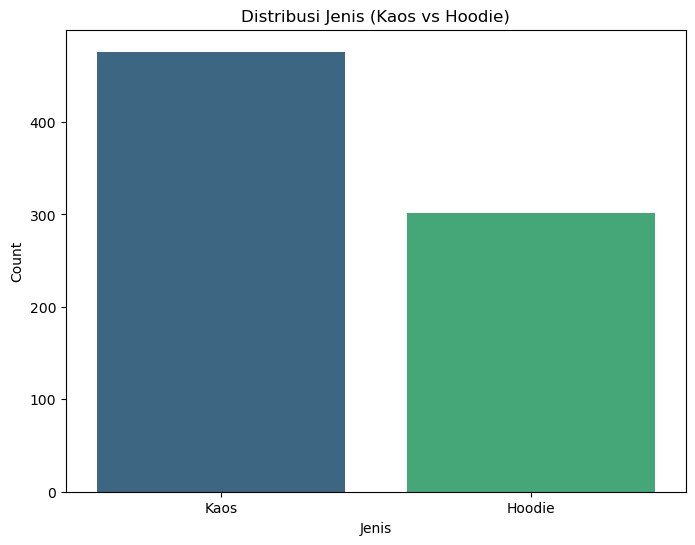

In [3]:
# Plot Distribution for 'Jenis'
plt.figure(figsize=(8, 6))
sns.countplot(x='jenis', data=df, palette='viridis')
plt.title('Distribusi Jenis (Kaos vs Hoodie)')
plt.xlabel('Jenis')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Kaos', 'Hoodie']) #0 kaos, 1 hoodie
plt.show()

C:\Users\mradi\AppData\Local\Temp\ipykernel_14532\3664176245.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='warna', data=df, palette='coolwarm')


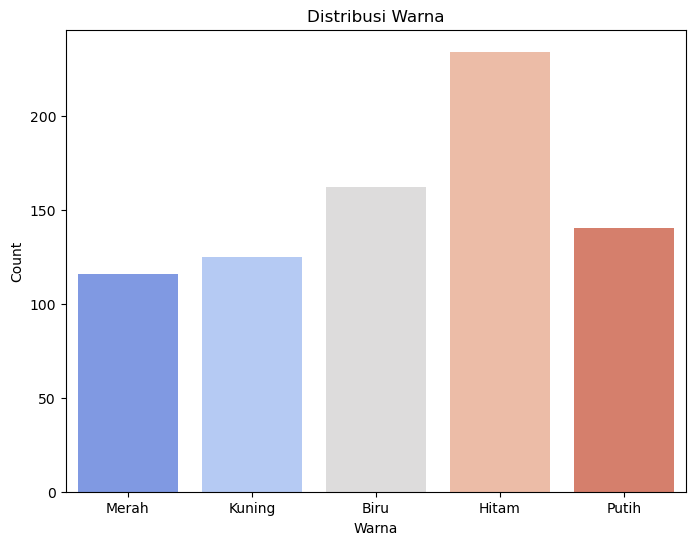

In [4]:
# Plot Distribution for 'Warna'
plt.figure(figsize=(8, 6))
sns.countplot(x='warna', data=df, palette='coolwarm')
plt.title('Distribusi Warna')
plt.xlabel('Warna')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['Merah', 'Kuning', 'Biru', 'Hitam', 'Putih']) 
plt.show()

### Preprocessing

In [5]:
# Hitung jumlah sampel per kelas (untuk 'jenis')
class_counts = df['jenis'].value_counts().sort_index().values
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

# Buat weight untuk setiap sampel
sample_weights = [class_weights[label] for label in df['jenis'].values]

# Buat sampler berdasarkan bobot
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [9]:
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224 for ResNet
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 0.8)),  # Resize image to 224x224 for ResNet
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

In [10]:
# Create Dataset
dataset = CustomDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

In [11]:
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

### Model

In [12]:
import torch.nn as nn
from torchvision import models

# Load Pretrained ResNet50
model = models.resnet50(pretrained=True)

# Modify the fully connected layer for dual output
num_ftrs = model.fc.in_features

# Create a custom head with two separate outputs
class MultiOutputModel(nn.Module):
    def __init__(self, num_ftrs, num_classes_jenis, num_classes_warna):
        super(MultiOutputModel, self).__init__()
        self.shared_layers = nn.Sequential(*list(model.children())[:-1])  # Use ResNet up to the second last layer
        self.fc_jenis = nn.Linear(num_ftrs, num_classes_jenis)  # Output for 'jenis'
        self.fc_warna = nn.Linear(num_ftrs, num_classes_warna)  # Output for 'warna'

    def forward(self, x):
        x = self.shared_layers(x)
        x = torch.flatten(x, 1)
        jenis_output = self.fc_jenis(x)
        warna_output = self.fc_warna(x)
        return jenis_output, warna_output

c:\Users\mradi\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mradi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Instantiate the model
num_classes_jenis = 2  # (0: Kaos, 1: Hoodie)
num_classes_warna = 5  # (0: merah, 1: kuning, 2:biru, 3: hitam, 4:putih)
model = MultiOutputModel(num_ftrs, num_classes_jenis, num_classes_warna)

In [14]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
# Loss function and optimizer
criterion_jenis = nn.CrossEntropyLoss()
criterion_warna = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2.719927949028397e-05)

### Training

In [16]:
# Training Loop
def train_model(model, dataloader, criterion_jenis, criterion_warna, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, jenis_labels, warna_labels in dataloader:
            # Move data to GPU if available
            images = images.to(device)
            jenis_labels = jenis_labels.to(device)
            warna_labels = warna_labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            jenis_outputs, warna_outputs = model(images)
            
            # Calculate loss for both outputs
            loss_jenis = criterion_jenis(jenis_outputs, jenis_labels)
            loss_warna = criterion_warna(warna_outputs, warna_labels)
            
            # Combine the losses (can be weighted differently if needed)
            loss = loss_jenis + loss_warna

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

    print("Finished Training")

In [17]:
# Train the model
train_model(model, dataloader, criterion_jenis, criterion_warna, optimizer, num_epochs=16)

Epoch [1/16], Loss: 1.5951
Epoch [2/16], Loss: 0.6285
Epoch [3/16], Loss: 0.2539
Epoch [4/16], Loss: 0.1373
Epoch [5/16], Loss: 0.1222
Epoch [6/16], Loss: 0.0651
Epoch [7/16], Loss: 0.0549
Epoch [8/16], Loss: 0.0429
Epoch [9/16], Loss: 0.0288
Epoch [10/16], Loss: 0.0297
Epoch [11/16], Loss: 0.0262
Epoch [12/16], Loss: 0.0238
Epoch [13/16], Loss: 0.0207
Epoch [14/16], Loss: 0.0154
Epoch [15/16], Loss: 0.0455
Epoch [16/16], Loss: 0.0174
Finished Training


### Evaluate with training dataset

In [18]:
def evaluate_model(model, dataloader):
    model.eval()  # Set to evaluation mode
    correct_jenis = 0
    correct_warna = 0
    correct_both = 0
    total = 0

    with torch.no_grad():
        for images, jenis_labels, warna_labels in dataloader:
            images = images.to(device)
            jenis_labels = jenis_labels.to(device)
            warna_labels = warna_labels.to(device)

            # Forward pass
            jenis_outputs, warna_outputs = model(images)

            # Get predictions
            _, jenis_predicted = torch.max(jenis_outputs.data, 1)
            _, warna_predicted = torch.max(warna_outputs.data, 1)

            total += jenis_labels.size(0)
            correct_jenis += (jenis_predicted == jenis_labels).sum().item()
            correct_warna += (warna_predicted == warna_labels).sum().item()
            correct_both += ((jenis_predicted == jenis_labels) & (warna_predicted == warna_labels)).sum().item()

    print(f"Accuracy (Jenis): {100 * correct_jenis / total:.2f}%")
    print(f"Accuracy (Warna): {100 * correct_warna / total:.2f}%")
    accuracy_both = 100 * correct_both / total if total > 0 else 0
    print(f"Accuracy (Both Correct): {accuracy_both:.2f}%")

# Example: Test the model (using the same dataloader here, but ideally, use a validation/test dataloader)
evaluate_model(model, dataloader)


Accuracy (Jenis): 100.00%
Accuracy (Warna): 100.00%
Accuracy (Both Correct): 100.00%


In [19]:
# torch.save(model, 'model/model_1.pth')

### Testing using test dataset

In [20]:
def predict_images(test_folder, device):
    results = []
    
    # Get a sorted list of image files based on numeric part of the file name
    img_files = sorted(
        [img_name for img_name in os.listdir(test_folder) if img_name.endswith(('.jpg', '.png'))],
        key=lambda x: int(os.path.splitext(x)[0])  # Sort by the numeric part of the filename
    )
    
    for img_name in img_files:
        img_id = os.path.splitext(img_name)[0]  # Get the ID from the file name
        img_path = os.path.join(test_folder, img_name)

        # Load and transform the image
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB mode
        image = transform(image).unsqueeze(0)  # Add batch dimension
        image = image.to(device)  # Move to the appropriate device

        # Make predictions
        with torch.no_grad():
            jenis_output, warna_output = model(image)
            _, jenis_predicted = torch.max(jenis_output.data, 1)
            _, warna_predicted = torch.max(warna_output.data, 1)

        # Store prediction results
        results.append({
            'id': int(img_id),  # Convert ID to integer for consistency
            'jenis': jenis_predicted.item(),  # Get the predicted class value
            'warna': warna_predicted.item()   # Get the predicted class value
        })
    
    return results


In [21]:
# Path ke folder gambar test
test_folder = "test/test"  # Ganti dengan path ke folder test Anda

# Melakukan prediksi
predictions = predict_images(test_folder, device)

# Membuat DataFrame dan menyimpan ke CSV
submission_df = pd.DataFrame(predictions)
submission_df.to_csv('submission_4_1.csv', index=False)  # Ganti dengan nama file yang diinginkan

print("Submission file 'submission.csv' has been created successfully!")

Submission file 'submission.csv' has been created successfully!


## Summary

Model ini digunakan untuk klasifikasi multi label yang mampu mengkategorikan produk berdasarkan jenis dan warna menggunakan *Convolutional Neural Network* berbasis arsitektur **ResNet50** dari **PyTorch** yang telah di *pretrained* secara lokal.
1. **Dataset**:
   - Dataset produk berupa gambar berlabel jenis dan warna, dengan label yang disediakan dalam `train.csv`.
   - Terdapat fungsi untuk memeriksa format file gambar (`.jpg` atau `.png`) dan *Custom Dataset Class* untuk mengakses gambar dan label.

2. **Transformasi Gambar**:
   - Melakukan tiga transformasi utama:
     - *Resize* ke 224x224 piksel.
     - Konversi gambar menjadi tensor.
     - Normalisasi menggunakan *mean* dan *standard deviation* RGB dari dataset ImageNet.

3. **Model Arsitektur**:
   - Model menggunakan ResNet50 dengan layer fully connected dimodifikasi menjadi dua output terpisah untuk klasifikasi jenis dan warna.

4. **Training dan Optimasi**:
   - Digunakan *CrossEntropyLoss* untuk kedua output, jenis dan warna, dan optimizer Adam dengan *batch size* 32.
   - Proses tuning menggunakan *Optuna* dengan *learning rate* dan *num_epochs* sebagai hyperparameter. Hasil terbaik dari tuning:
     - *Learning rate*: 2.719927949028397e-05
     - *Epochs*: 16
     - Akurasi rata-rata tertinggi mencapai 1.0 pada *trial* terbaik.

5. **Prediksi pada Test Set**:
   - Fungsi `predict_images` menghasilkan prediksi jenis dan warna dari gambar dalam folder `test/test`.
   - Hasil prediksi disimpan dalam CSV `submission_6.csv`.